# Basic Reinforcement Learning
Purpose: To learn about RL from its most basic instantiation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import copy

In [2]:
import gym

In [3]:
#env = gym.make('LunarLander-v2')

# Agent

In [4]:
class Agent():
    '''
     class Agent
     
     Represents an RL agent. Its Q function is represented by a neural network, so that
       agent.Q(s) returns a vector of probabilities over action-space.
    '''
    def __init__(self, env):
        '''
         ag = Agent(env)
         
         Instantiates an Agent object.
         
         Inputs:
           env  the environment for the task
        '''
        self.env = env
        self.state_dim = self.env.observation_space.shape[0]  #state_dim
        self.n_actions = self.env.action_space.n  #n_actions
        self.state = torch.zeros(self.state_dim)
        
        # Policy
        self.hidden = 20
        self.Q = torch.nn.Sequential(
                    torch.nn.Linear(self.state_dim, self.hidden),
                    torch.nn.Sigmoid(),
                    torch.nn.Linear(self.hidden, self.n_actions),
                    torch.nn.Softmax(dim=0))
        
        # Value function
        self.V_hidden = 30
        self.V = torch.nn.Sequential(
                    torch.nn.Linear(self.state_dim, self.V_hidden),
                    torch.nn.Sigmoid(),
                    torch.nn.Linear(self.V_hidden, 1))
        
        # Eligibility-trace buffer for Q
        self.Qz = []
        for p in self.Q.parameters():
            self.Qz.append(torch.zeros_like(p))
            
        # Eligibility-trace buffer for V
        self.Vz = []
        for p in self.V.parameters():
            self.Vz.append(torch.zeros_like(p))
        
    def sample(self, p):
        '''
         idx = ag.sample(p)
         
         Randomly choose an index according to the probability vector p.
         
         Input:
           p  is a probability vector
           
         Output:
           idx is an index of the vector p
        '''
        c = torch.zeros_like(p)
        c[0] = p[0]
        for k in range(1,len(c)):
            c[k] += p[k] + c[k-1]
        r = np.random.rand()
        result = np.where(r>c)
        return len(result[0])

    def SetState(self, state):
        if isinstance(state, (np.ndarray, list,)):
            self.state = torch.tensor(state, dtype=torch.float)
        elif isinstance(state, (torch.FloatTensor, )):
            self.state = state.detach().clone()
            
    def ChooseAction(self, state=None, eps=0.):
        '''
         A = ag.ChooseAction(state, eps=0.)
         
         Choose an action, given the state.
         With probability eps, it will choose an action randomly.
         Otherwise, it will choose an action that yields the highest Q-value.
        '''
        if isinstance(state, (list, np.ndarray, torch.FloatTensor)):
            self.SetState(state)
            
        if np.random.rand()>=eps:
            Pa = self.Q(self.state)
            A = self.sample(Pa)
        else:
            A = np.random.randint(0, self.n_actions)
        return A
    
    def Episode(self, gamma=1.):
        '''
         traj, G = ag.Episode(gamma=1.)
         
         Runs one episode, and returns the trajectory. The environment is
         automatically reset at the beginning of the episode.
                 
         Inputs:
           gamma  reward discount
         
         Outputs:
           traj trajectory, as a list of lists of the form
                [A, S, Snext, R, G, done, info]
                A     action taken at state S
                S     state
                Snext state after taking action A
                R     reward
                G     future return (discounted)
                done  flag to indicate episode is done
                info  not sure ?
        '''
        S = self.env.reset()
        traj = []
        G0 = 0.
        gamma_k = gamma
        for k in range(self.env._max_episode_steps):
            action = self.ChooseAction(state=S)
            Snext, r, done, info = self.env.step(action)
            traj.append([action, S, Snext, r, 0., done, info])
            G0 += gamma_k * r
            gamma_k *= gamma
            S = Snext
            if done:
                break
        # Use that trajectory (and rewards) to update the policy parameters
        # Process the return for all visited states
        traj[-1][4] = 0.
        for k in range(len(traj)-2, -1, -1):
            traj[k][4] = traj[k][3] + gamma*traj[k+1][4]
        return traj
    
    def REINFORCE(self, gamma=1.0, alpha=0.0001):
        '''
         ag.REINFORCE(env, gamma=1.0, alpha=0.0001)
         
         Performs an episode of the REINFORCE algorithm, following a reset
         of the environment.
         
         Inputs:
           gamma  discount rate for rewards (default 1.0)
           alpha  step size for gradient ascent (the policy gradient)
           
         Output:
           traj   trajectory, a list of lists of the form:
                [A, S, Snext, R, G, done, info]
                A     action taken at state S
                S     state
                Snext state after taking action A
                R     reward
                G     future return (discounted)
                done  flag to indicate episode is done
                info  not sure ?
        '''
        # Perform an episode and record the trajectory
        traj = self.Episode()
                
        # Update policy parameters
        for k,blah in enumerate(traj):
            G = blah[4]  # future return
            # Set up network state
            A = blah[0]
            S = torch.tensor(blah[1], dtype=torch.float)
            Pa = self.Q(S)
            #err = Pa[A]
            # Backproject gradient
            self.Q.zero_grad()
            Pa[A].backward()
            with torch.no_grad():
                for p in self.Q.parameters():
                    p += alpha * gamma**k * G * p.grad / Pa[A]
        return traj
    
    def REINFORCE_baseline(self, gamma=1.0, alpha=0.0001, alpha_v=0.0001):
        '''
         ag.REINFORCE_baseline(env, gamma=1.0, alpha=0.0001, alpha_v=0.0001)
         
         Performs an episode of the REINFORCE algorithm with baseline, following
         a reset of the environment. This method computes a model of the value
         function, in addition to a policy.
         
         Inputs:
           gamma  discount rate for rewards (default 1.0)
           alpha  step size for gradient ascent (the policy gradient)
           alpha_v step size for gradient ascent of the value function
           
         Output:
           traj   trajectory, a list of lists of the form:
                  [A, S, Snext, R, G, done, info]
                  A     action taken at state S
                  S     state
                  Snext state after taking action A
                  R     reward
                  G     future return (discounted)
                  done  flag to indicate episode is done
                  info  not sure ?
        '''
        v_mult = 10.
        
        # Perform an episode and record the trajectory
        traj = self.Episode()
                
        # Update policy parameters
        gamma_t = gamma
        for k,blah in enumerate(traj):
            G = blah[4]  # future return
            
            # Policy network
            A = blah[0]
            S = torch.tensor(blah[1], dtype=torch.float)
            Pa = self.Q(S)
            
            # Value network
            V = self.V(S)*v_mult
            
            # Error
            err = G - V
            
            
            # Backproject gradient
            self.Q.zero_grad()
            self.V.zero_grad()
            V.backward()
            Pa[A].backward()
            with torch.no_grad():
                for p in self.Q.parameters():
                    p += alpha * gamma_t * err * p.grad / Pa[A]
                for p in self.V.parameters():
                    p += alpha_v * gamma_t * err * p.grad / v_mult
            
            gamma_t *= gamma
        return traj

    def ActorCritic_ET(self, gamma=1.0, alpha=0.001, alpha_v=0.001, lam=0.9, lam_v=0.9):
        '''
         ag.ActorCritic_ET(gamma=1.0, alpha=0.0001, alpha_v=0.0001, lam=0.9, lam_v=0.9)
         
         Actor-Critic with Eligibility Trace
        '''
        v_mult = 1.

        S = torch.tensor(self.env.reset(), dtype=torch.float)
        traj = []
        
        # Zero the eligibility-trace buffers
        for p in self.Qz:
            p.zero_()
        for p in self.Vz:
            p.zero_()
        
        I = 1.
        traj = []
        
        for k in range(self.env._max_episode_steps):
            Pa = self.Q(S)
            A = self.ChooseAction(S)
            #A = torch.argmax(Pa).item()
            Snext, r, done, info = self.env.step(A)
            Snext = torch.tensor(Snext, dtype=torch.float)

            traj.append([A, S, Snext, r, 0., done, info])
 
            V = self.V(S)*v_mult
            Vnext = self.V(Snext)*v_mult
            
            delta = r + gamma*Vnext - V
            delta2 = torch.pow(delta, 2)
            
            self.Q.zero_grad()
            self.V.zero_grad()
            
            #Pa[A].backward()
            #V.backward()
            logPi = torch.log(Pa[A])
            logPi.backward()
            delta2.backward()
            
            with torch.no_grad():
                for p,z in zip(self.V.parameters(), self.Vz):
                    z *= gamma*lam_v
                    z += I*p.grad/v_mult
                    #p -= alpha_v*delta*z
                    p -= alpha_v*z
                for p,z in zip(self.Q.parameters(), self.Qz):
                    z *= gamma*lam
                    #z += I*p.grad/Pa[A]
                    z += I*p.grad
                    p += alpha*delta*z
            
            I *= gamma
            S = Snext
            
            if done:
                break
        
        return traj

        
    def Simulate(self, trials=1):
        time.sleep(1)
        avg_k = 0.
        for trial in range(trials):
            observation = self.env.reset()
            for k in range(self.env._max_episode_steps):
                self.env.render()
                action = self.ChooseAction(torch.tensor(observation, dtype=torch.float))

                observation, reward, done, info = self.env.step(action)

                if done:
                    print('Done after '+str(k))
                    avg_k += k
                    break
        print('Average reward: '+str(avg_k/trials))
        time.sleep(1)
        self.env.close()

# Train model

## Actor-Critic with eligibility traces

In [22]:
env = gym.make('CartPole-v0')

S = env.reset()
ag_ac = Agent(env)
ag_ac.env._max_episode_steps = 500

In [21]:
ag_ac.Simulate(5)

Done after 109
Done after 116
Done after 113
Done after 118
Done after 163
Average reward: 123.8


In [23]:
score = []
counter = 0
mysum = 0
interval = 50

In [24]:
for i_episode in range(500):
    traj = ag_ac.ActorCritic_ET(gamma=1., alpha=0.5, alpha_v=0.5, lam=0., lam_v=0.)
    counter += 1
    mysum += len(traj)
    if counter%interval==0:
        score.append(mysum/interval)
        mysum = 0

In [26]:
for i_episode in range(500):
    traj = ag_ac.ActorCritic_ET(gamma=1., alpha=0.1, alpha_v=0.1, lam=0., lam_v=0.)
    counter += 1
    mysum += len(traj)
    if counter%interval==0:
        score.append(mysum/interval)
        mysum = 0

In [29]:
for i_episode in range(500):
    traj = ag_ac.ActorCritic_ET(gamma=1., alpha=0.01, alpha_v=0.02, lam=0., lam_v=0.)
    counter += 1
    mysum += len(traj)
    if counter%interval==0:
        score.append(mysum/interval)
        mysum = 0

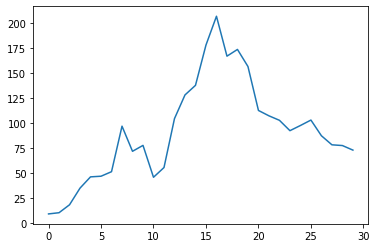

In [30]:
plt.plot(score);

In [28]:
ag_ac.Simulate(10)

Done after 110
Done after 96
Done after 113
Done after 122
Done after 104
Done after 129
Done after 100
Done after 99
Done after 160
Done after 116
Average reward: 114.9


In [50]:
S = ag_ac.env.reset()
print(S)
ag_ac.V(torch.tensor(S, dtype=torch.float))

[-0.04749137  0.00010178  0.02510135  0.01839708]


tensor([74.6678], grad_fn=<AddBackward0>)

## REINFORCE

In [10]:
env = gym.make('CartPole-v0')

S = env.reset()
ag_r = Agent(env)
ag_r.env._max_episode_steps = 500

In [6]:
score = []
counter = 0
mysum = 0
interval = 50

In [13]:
for i_episode in range(1000):
    traj = ag_r.REINFORCE(alpha=0.0001)
    counter += 1
    mysum += len(traj)
    if counter%interval==0:
        score.append(mysum/interval)
        mysum = 0

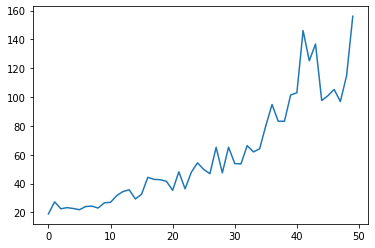

In [14]:
plt.plot(score);

## REINFORCE with Baseline

In [10]:
env = gym.make('CartPole-v0')

S = env.reset()
ag_rb = Agent(env)
ag_rb.env._max_episode_steps = 500

In [42]:
score2 = []
counter = 0
mysum = 0
interval = 50

In [62]:
for i_episode in range(500):
    traj = traj = ag_rb.REINFORCE_baseline(alpha=0.00001, alpha_v=0.0001)
    counter += 1
    mysum += len(traj)
    if counter%interval==0:
        score2.append(mysum/interval)
        mysum = 0

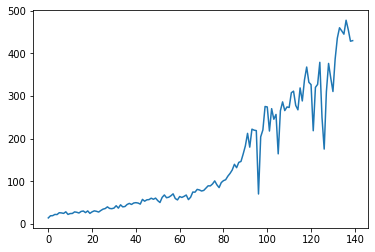

In [63]:
plt.plot(score2);

In [19]:
S = ag_rb.env.reset()
print(S)
ag.V(torch.tensor(S, dtype=torch.float))

[-0.01820983  0.01047394  0.02722696  0.04937856]


tensor([-0.3154], grad_fn=<AddBackward0>)

In [63]:
ag_rb.V(torch.tensor([0, 0, 0, 0], dtype=torch.float))

tensor([17.9258], grad_fn=<AddBackward0>)